In [1]:
%pip install -q matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

%matplotlib inline

### Reading Animelist.csv

In [4]:
INPUT_DIR = os.path.join("..","Artifacts","raw")

In [5]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=["user_id","anime_id","rating"])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

### Data Processing

In [7]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])
max_rating = max(rating_df["rating"])

In [10]:
min_rating,avg_rating,max_rating

(0, np.float64(4.122732695114736), 10)

In [11]:
rating_df["rating"] = rating_df["rating"].apply(lambda x:(x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [12]:
min_rating = min(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])
max_rating = max(rating_df["rating"])

In [13]:
min_rating,avg_rating,max_rating

(0.0, np.float64(0.4122732695114736), 1.0)

In [14]:
rating_df.duplicated().sum()

np.int64(0)

In [15]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [16]:
user_ids = rating_df["user_id"].unique().tolist()

In [17]:
user2user_encoding = {x:i for i,x in enumerate(user_ids)}
user2user_decoding = {i:x for i,x in enumerate(user_ids)}

In [18]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoding)

In [19]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [20]:
n_users = len(user2user_encoding)
n_users

4203

In [21]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoding = {x:i for i,x in enumerate(anime_ids)}
anime2anime_decoding = {i:x for i,x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoding)

In [22]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [23]:
n_anime = len(anime2anime_encoding)
n_anime

17149

In [24]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)


In [25]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [26]:
x = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [27]:
test_size = 1000

train_indices = rating_df.shape[0] - test_size

In [28]:
x_train,x_test,y_train,y_test = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [29]:
len(x_train),len(x_test)

(3245641, 1000)

In [30]:
type(x_train)

numpy.ndarray

In [31]:
x_train_array = [x_train[:,0], x_train[:,1]]
x_test_array = [x_test[:,0], x_test[:,1]]


In [32]:
type(x_train_array)

list

In [33]:
type(x_train_array[0])

numpy.ndarray

### Model Architecture

In [34]:
def recommenderNET():

    embedding_size = 128

    user = Input(name="user",shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product",normalize=True,axes=2)([user_embedding,anime_embedding])
    x = Flatten()(x)  
    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime],outputs = x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"], optimizer = 'Adam')

    return model





In [35]:
model = recommenderNET()

In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [37]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr


In [38]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch),verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, mode='min', save_best_only=True)
early_stopping = EarlyStopping(patience=3,monitor='val_loss', mode='min',restore_best_weights=True)


In [39]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [40]:
history = model.fit(x=x_train_array,
          y=y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=(x_test_array,y_test),
          callbacks = my_callbacks)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.7509 - mae: 0.3730 - mse: 0.1804 - val_loss: 0.6969 - val_mae: 0.3624 - val_mse: 0.1576 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - loss: 0.7477 - mae: 0.3719 - mse: 0.1791 - val_loss: 0.7277 - val_mae: 0.3705 - val_mse: 0.1718 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.7424 - mae: 0.3700 - mse: 0.1768 - val_loss: 0.7468 - val_mae: 0.3753 - val_mse: 0.1797 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.7351 - mae: 0.3673 - mse: 0.1737 - val_loss: 0.7439 - val_mae: 0.3745 - val_mse: 0.1785 - learning_rate: 3.4000e-05


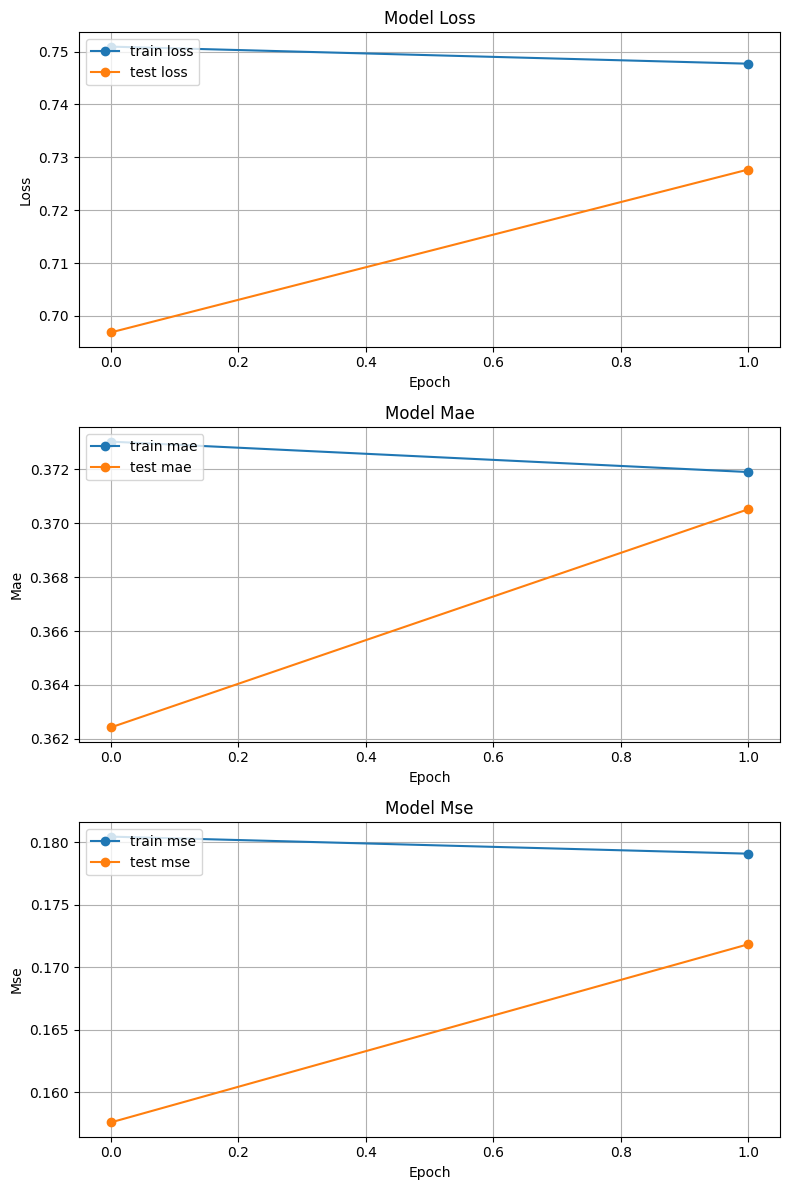

In [41]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [46]:
def extract_weigths(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights


In [47]:
anime_weights = extract_weigths('anime_embedding',model)
anime_weights

array([[-0.08527679, -0.00975026,  0.00439352, ...,  0.0387902 ,
        -0.06620301, -0.06084907],
       [ 0.0897717 ,  0.01897309, -0.0672172 , ...,  0.04825416,
        -0.12543559, -0.08889911],
       [-0.14141254, -0.11736367,  0.01147817, ...,  0.10466601,
        -0.0583768 , -0.14299004],
       ...,
       [ 0.10966034, -0.07732698,  0.1029112 , ..., -0.08685873,
        -0.1215461 , -0.01278225],
       [ 0.0249489 , -0.04448079, -0.11808345, ..., -0.08524046,
        -0.11137944, -0.13487825],
       [-0.13703896, -0.03731946,  0.1359108 , ...,  0.08527634,
         0.07202986, -0.10138724]], shape=(17149, 128), dtype=float32)

In [48]:
user_weights = extract_weigths('user_embedding',model)
user_weights

array([[-0.12487018, -0.080197  ,  0.01770436, ..., -0.1006709 ,
         0.11744379,  0.09199189],
       [-0.01371356,  0.03874201,  0.08498032, ...,  0.13739727,
         0.04256895,  0.01452809],
       [ 0.02804029,  0.11347382, -0.14935096, ...,  0.00809322,
         0.1386633 , -0.07935233],
       ...,
       [ 0.00079264,  0.06821328, -0.05256885, ...,  0.12182768,
         0.04158062,  0.10995376],
       [-0.14399767, -0.10381668, -0.06908452, ..., -0.06468025,
         0.1006256 , -0.05791868],
       [ 0.01856874,  0.09100491, -0.1047706 , ...,  0.01775165,
         0.03449196, -0.121291  ]], shape=(4203, 128), dtype=float32)

##### READING ANIME.csv

In [51]:
df = pd.read_csv(INPUT_DIR+'/anime.csv',low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [ ]:
df = df.replace("Unknown",np.nan)

In [58]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id==anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id== anime_id].Name.values[0]
    except:
        print('error')

    return name





In [59]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x:getAnimeName(x))

In [60]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [61]:
df.sort_values(by=['Score'],
               inplace=True,
               ascending=False,
               kind='quicksort',
               na_position='last')

In [63]:
df.head(3)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate


In [66]:
df = df[['anime_id','eng_version','Score','Genres','Episodes','Type','Premiered','Members']]

In [67]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [68]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id==anime]
    
    if isinstance(anime,str):
        return df[df.eng_version==anime]

In [71]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [72]:
getAnimeFrame('Attack on Titan Final Season',df)


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


##### Anime_with_synopsis.csv

In [76]:
cols = ['MAL_ID','Name','Genres','sypnopsis']


In [77]:
synopsis_df = pd.read_csv(INPUT_DIR+'/anime_with_synopsis.csv',usecols=cols)
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [169]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return df[df.MAL_ID==anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return df[df.Name==anime].sypnopsis.values[0]

In [170]:
getSynopsis('Cowboy Bebop: Tengoku no Tobira',synopsis_df)

'other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized.'

In [171]:
getSynopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

#### Content/Item Based Reccomendation System

In [82]:
pd.set_option('max_colwidth',None)

In [250]:
def find_similar_animes(name,anime_weights,anime2anime_encoded,anime2anime_decoded,
                        df,synopsis_df,n=10,return_dist=False,neg=False):
    
    try:
        index=getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        print(f"anime closest to {name}")


        if return_dist:
            return dists,closest

        SimilarityArr = []

        for close in closest:
            decoded_id=anime2anime_decoded.get(close)  

            synopsis = getSynopsis(int(decoded_id),synopsis_df)
            anime_frame = getAnimeFrame(int(decoded_id),df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id":decoded_id,
                "name":anime_name,
                "similarity":similarity,
                "genre":genre,
                "synopsis":synopsis
            })

        frame = pd.DataFrame(SimilarityArr).sort_values(by='similarity',ascending=False)
        
        return frame[frame.anime_id!=index].drop(['anime_id'],axis=1)
        
    except Exception as e:
        print('error occured',e)





In [251]:
find_similar_animes(
    "Attack on Titan Final Season",
    anime_weights,
    anime2anime_encoding,
    anime2anime_decoding,
    df,
    synopsis_df,
)

anime closest to Attack on Titan Final Season


,name,similarity,genre,synopsis
9,Peeping Life: The Perfect Explosion Specials,0.350418,"Slice of Life, Comedy","Specials included on the DVD release of Peeping Life: The Perfect Explosion that focus on Otaku-kun talking about ""Celebrating Universal's 100th Anniversary"" and Otaku-kun interacting with a animegao kigurumi performer in ""Madeleine and the Pocket Tissues."""
8,Hello Kitty no Minna no Mori wo Mamore!,0.323751,Kids,"One day, Kitty notices a part of the forest she plays in almost every day has died. Insects come and ask Kitty to help fight a witch who is causing it."
7,Kekkou Kamen,0.316037,"Comedy, Ecchi","he academy Miami Takashi attends, higher education has sunk to the lowest levels of depravity, with armed hall monitors, teachers who wear masks to hide their identities and special detention sessions in a torture chamber beneath the gym! It's a curriculum designed to chew up sweet young things, and poor Miami's been voted ""Least Likely to Survive"" in her class! Is there no hope? Can no one save her? Enter Kekko Kamen, the most outrageous superheroine ever! Clad in a red mask, red boots and nothing else, she is the supreme protector of innocents like Miami. Armed with her trusty nunchaku and a body that just won't quit, she'll make chopped pork out of the swine who run this school from hell! But who is she really? The only one who knows for sure is creator Go Nagai and he's not giving anything away... except lots of free peeks at Kekko Kamen's magnificent physique! (Source: AniDB)"
6,Ichirin-sha,0.313371,"Action, Mecha, Sci-Fi, Seinen","On a planet very similar to the earth... Here, the missile mechanoids started to have its own will and control, and were driving the human beings into serious danger. Shaleen was the last ICHIRIN-SHA (unicyclist) in the world, traveling the world on his beat up motor unicycle. One day, when Shaleen was running from the attacks of the missile mechanoids, he stops by a ghost town and meets a mysterious girl who was constantly targeted by the mechanoids. Note: Originally meant to be a full length movie, the project was cancelled, but a 7 minutes long trailer was released before that. (Source: AniDB)"
5,Spooky Kitaro:Japan Explodes!!,0.289885,"Action, Fantasy, Horror, Kids, Shounen, Supernatural",ovie based on the 2007 TV anime with an original plot.
4,Dog Days'': Gravure Talk,0.288590,"Comedy, Ecchi, Fantasy",Four picture dramas included on the bonus DVD.
3,Kuma no Gakkou: Patissier Jackie to Ohisama no Sweets,0.287077,"Comedy, Kids",NaN
2,Kiki to Lala no Ohimesama ni Naritai,0.285639,Kids,Kiki and Lala are preparing for Hoshi Matsuri and dreaming of all the fun things they can wish for themselves if they spot a falling star.
1,Mameshiba the DVD Green Pea-shiba no Kutsujoku,0.281000,Comedy,"DVD release of Mameshiba which contained 4 new episodes featuring stop-motion animation, two of which show Green Pea being humiliated and is what the full title of the DVD is named after. The other two episodes show Red Bean catching a cold and Cashew rolling around before being stepped on."
0,Mobile Suit Gundam SEED: After-Phase Between the Stars,0.277025,"Action, Drama, Mecha, Sci-Fi","s the war between ZAFT's Coordinators and Earth's Naturals comes to a close, the survivors of the conflict recuperate. Some of these veterans heal with the aid of loved ones, and others choose to recover in isolation, reflecting on their losses and the friends no longer with them. In this epilogue to the hardships of Kira Yamato and Athrun Zala, the heroes come to terms with their roles in the recent war and prepare for adventures yet to come."


#### User Based/ Collaborative filtering

In [189]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [192]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [196]:
find_similar_users(15851,user_weights,user2user_encoding,user2user_decoding)

,similar_users,similarity
9,9373,0.296637
8,7283,0.289599
7,12034,0.272159
6,11119,0.263887
5,3381,0.259972
4,11234,0.257127
3,4724,0.256897
2,1878,0.253200
1,860,0.248488
0,1671,0.247383


In [150]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [151]:
from collections import defaultdict

In [152]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [158]:
def get_user_preferences(user_id, rating_df, df, verbose=0, plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    
    user_rating_percentile = np.percentile(animes_watched_by_user.rating,75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating>=user_rating_percentile]

    top_anime_by_user = (
        animes_watched_by_user.sort_values(by=['rating'],ascending=False).anime_id.values 
    )

    anime_df_rows = df[df['anime_id'].isin(top_anime_by_user)]
    anime_df_rows = anime_df_rows[['eng_version','Genres']]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows


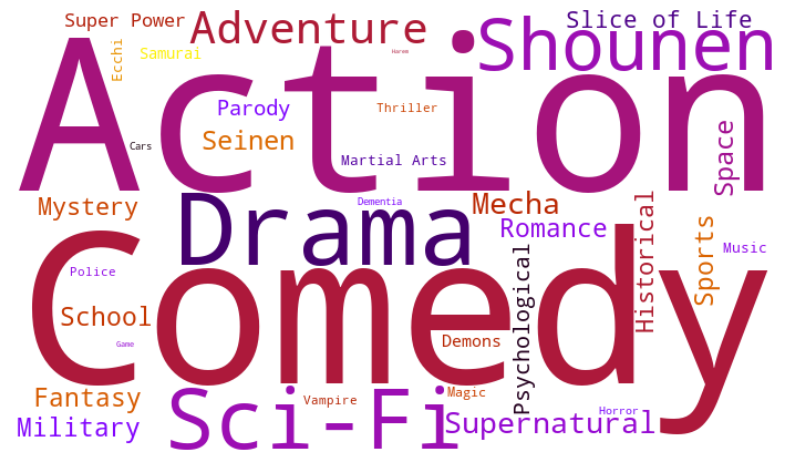

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [160]:
get_user_preferences(11880, rating_df,df,plot=True)

In [244]:
def get_user_reccomendation(similar_users, user_pref, df, rating_df, synopsis_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id),rating_df,df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]  

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
            
    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i,anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name,str):
                frame = getAnimeFrame(anime_name,df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id),synopsis_df)
            

                recommended_animes.append({
                    'n':n_user_pref,
                    'anime_id':anime_id,
                    'anime_name':anime_name,
                    'Genres':genre,
                    'Synopsis':synopsis
                })

        return pd.DataFrame(recommended_animes).head(n) 
        



In [245]:
similar_users = find_similar_users(11880,user_weights,user2user_encoding,user2user_decoding)
user_preferences = get_user_preferences(11880, rating_df,df,plot=False)

In [246]:
get_user_reccomendation(similar_users,user_preferences,df,rating_df ,synopsis_df,n=5)

,n,anime_id,anime_name,Genres,Synopsis
0,8,1575,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
1,7,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural","Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While trying to regain his memories and understand Tenshi, he gradually unravels the mysteries of the afterlife."
2,7,18153,Beyond the Boundary,"Slice of Life, Supernatural, Fantasy","ai Kuriyama is the sole survivor of a clan of Spirit World warriors with the power to employ their blood as weapons. As such, Mirai is tasked with hunting down and killing ""youmu""—creatures said to be the manifestation of negative human emotions. One day, while deep in thought on the school roof, Mirai comes across Akihito Kanbara, a rare half-breed of youmu in human form. In a panicked state, she plunges her blood saber into him only to realize that he's an immortal being. From then on, the two form an impromptu friendship that revolves around Mirai constantly trying to kill Akihito, in an effort to boost her own wavering confidence as a Spirit World warrior. Eventually, Akihito also manages to convince her to join the Literary Club, which houses two other powerful Spirit World warriors, Hiroomi and Mitsuki Nase. As the group's bond strengthens, however, so does the tenacity of the youmu around them. Their misadventures will soon turn into a fight for survival as the inevitable release of the most powerful youmu, Beyond the Boundary, approaches."
3,7,16498,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childh

##### Hybrid reccomender system

In [258]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):

    #User reccomndation

    similar_users = find_similar_users(user_id,user_weights,user2user_encoding,user2user_decoding)
    user_preferences = get_user_preferences(user_id, rating_df,df,plot=False)
    user_recommended_animes = get_user_reccomendation(similar_users,user_preferences,df,rating_df,synopsis_df)
    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()

    ### content recomnedation
    
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime,anime_weights,anime2anime_encoding,anime2anime_decoding,df,synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime]=combined_scores.get(anime,0)+user_weight

    for anime in content_recommended_animes:
        combined_scores[anime]=combined_scores.get(anime,0)+content_weight


    sorted_animes = sorted(combined_scores.items(),key=lambda x:x[1],reverse=True)

    return [anime for anime, score in sorted_animes[:10]]
  



In [ ]:
hybrid_recommendation(4903)

anime closest to Nisekoi:False Love
anime closest to Bakemonogatari
anime closest to No Game, No Life
anime closest to KILL la KILL
anime closest to Re:ZERO -Starting Life in Another World-
anime closest to The Melancholy of Haruhi Suzumiya
error occured index 0 is out of bounds for axis 0 with size 0
No similar anime found The Melancholy of Haruhi Suzumiya
anime closest to anohana:The Flower We Saw That Day
anime closest to Code Geass:Lelouch of the Rebellion R2
error occured index 0 is out of bounds for axis 0 with size 0
No similar anime found Code Geass:Lelouch of the Rebellion R2
anime closest to Bakuman.
error occured index 0 is out of bounds for axis 0 with size 0
No similar anime found Bakuman.
anime closest to Fairy Tail
error occured index 0 is out of bounds for axis 0 with size 0
No similar anime found Fairy Tail


['Nisekoi:False Love',
 'Bakemonogatari',
 'No Game, No Life',
 'KILL la KILL',
 'Re:ZERO -Starting Life in Another World-',
 'The Melancholy of Haruhi Suzumiya',
 'anohana:The Flower We Saw That Day',
 'Code Geass:Lelouch of the Rebellion R2',
 'Bakuman.',
 'Fairy Tail']

: 